In [1]:
# !pip install neurodsp
# !pip install emd
# !pip install umap-learn
# !pip install -U kaleido

In [2]:
# Load required libraries
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
import umap.umap_ as umap
from scipy.spatial import cKDTree
import pickle
import os
from plotly.graph_objs.layout import Scene
from plotly.graph_objs.layout.scene import XAxis, YAxis, ZAxis
import plotly.graph_objects as go

# Import custom functions
from scripts.functions import *

def get_section(start_sample, fs=2500):
    if start_sample/(fs*60) <= 45:
        return 1
    elif start_sample/(fs*60) <= 90:
        return 2
    elif start_sample/(fs*60) <= 135:
        return 3
    return 4

sns.set(style='white', context='notebook')

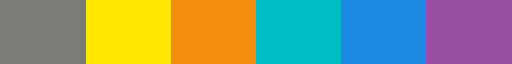

In [29]:
import matplotlib as mpl
cmap = mpl.colors.ListedColormap(["#7B7B7A", "#FFE701", "#F38F0D", "#00bfc4", "#1E88E5", "#984ea3"])
state_color_map = {
    0: "#7B7B7A",
    1: "#FFE701",
    2: "#F38F0D",
    3: "#00bfc4",
    4: "#1E88E5",
    5: "#984ea3",
}
cmap

In [378]:
# Set path to LFP data and sleep state files
path_to_data = './data/OS_basic_separated/13/Rat_OS_Ephys_Rat13_344994_SD11_OR_N_06-07_06_2019/'
data_file = 'Cleaned_Trial1_PFC_100_CH63_0.continuous.mat'
states_file = '2019-06-06_11-44-01_post_trial1-states.mat'
pfc_data1, sleep_scoring1 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial2_PFC_100_CH63_0.continuous.mat'
states_file = '2019-06-06_12-34-54_post_trial2-states.mat'
pfc_data2, sleep_scoring2 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial3_PFC_100_CH63_0.continuous.mat'
states_file = '2019-06-06_13-26-20_post_trial3-states.mat'
pfc_data3, sleep_scoring3 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial4_PFC_100_CH63_0.continuous.mat'
states_file = '2019-06-06_14-17-32_post_trial4-states.mat'
pfc_data4, sleep_scoring4 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial5_PFC_100_CH63_0.continuous.mat'
states_file = '2019-06-06_15-39-11_post_trial5-states.mat'
pfc_data5, sleep_scoring5 = load_mat_data(path_to_data, data_file, states_file)

# Plots

In [ ]:
fig = px.scatter_3d(x=pt5_data['emb1'], y=pt5_data['emb2'], z=pt5_data['emb3'],
              color=pt5_data['State'], color_discrete_map=state_color_map)

fig.update_layout(coloraxis_colorbar_title_text = 'State',
                 autosize=False,
                 width=800,
                 height=600,
                 scene=Scene(xaxis=XAxis(title='UMAP-1'),
                            yaxis=YAxis(title='UMAP-2'),
                            zaxis=ZAxis(title='UMAP-3')),
                  legend_title_text="State"
)
fig.show()
# fig.write_html(f"./plots/UMAP-ORN-Whole/PostTrial5_ORN_PFC_embedding.html")

In [ ]:
# Split 3D plot with projected sleep states
data = deepcopy(pt5_data)

# Assign section based on start_sample and create z_offset using height_offsets
height_offsets = {1: 0, 2: 10, 3: 20, 4: 30}
data['z_offset'] = data['emb3'] + np.array(data['section'].map(height_offsets))

fig = px.scatter_3d(
    x=data['emb1'], 
    y=data['emb2'], 
    z=data['z_offset'],
    color=data['State'],
    color_discrete_map=state_color_map
)

for section, z_pos in height_offsets.items():
    fig.add_trace(
        go.Scatter3d(
            x=[-5], y=[10], z=[z_pos + 5],
            mode='text',
            text=f"{(section-1)*45} - {section*45} minutes",
            textfont=dict(size=12, color='black'),
            showlegend=False
        )
    )

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    scene=dict(
        xaxis=dict(title='UMAP-1'),
        yaxis=dict(title='UMAP-2'),
        zaxis=dict(title='UMAP-3')
    ),
    legend_title_text="State"
)
fig.show()
# fig.write_html(f"./plots/UMAP-ORN-Whole/PostTrial5_ORN_PFC_split_embedding.html")
# fig.write_image("Rat13_ORN_split_embedding.png", engine="kaleido")

In [ ]:
# 3D plots of features projected on UMAP
data = pt5_data
feature = 'peak2trough'

fig = px.scatter_3d(x=data['emb1'], y=data['emb2'], z=data['emb3'],
              color=data[feature])
fig.update_layout(autosize=False,
                  width=800,
                  height=600,
                  scene=Scene(xaxis=XAxis(title='UMAP-1'),
                            yaxis=YAxis(title='UMAP-2'),
                            zaxis=ZAxis(title='UMAP-3')),
                  coloraxis_colorbar_title=feature,
                  coloraxis=dict(
                        cmin=np.percentile(data[feature], 5),  # Minimum value for the color scale (you can also use the 5th percentile if preferred)
                        cmax=np.percentile(data[feature], 95)  # Maximum value for the color scale (95th percentile)
                  )
)
fig.show()
# fig.write_html(f"./plots/UMAP-ORN-Whole/PostTrial5_ORN_embedding_{feature}.html")
# fig.write_image(f"{}_ORN_3D_embedding.png", engine="kaleido")

### 2D Feature Plots

In [ ]:
data = metrics

# cmap = plt.get_cmap('gist_rainbow', 6)
# cmap = mpl.colors.ListedColormap(["navy", "crimson", "limegreen", "gold"])
f, ax = plt.subplots(1,3, figsize=(12,4))
s = ax[0].scatter(emb[:,0], emb[:,1], c=data['State'],
            cmap=cmap, s=25, edgecolor ='none')
ax[0].set_xlabel('UMAP-1', fontsize=10)
ax[0].set_ylabel('UMAP-2', fontsize=10)
ax[0].set_title('Sleep State', fontsize=10)
f.colorbar(s, ax=ax[0])

s = ax[1].scatter(emb[:,0], emb[:,2], c=data['State'],
            cmap=cmap, s=25)
ax[1].set_xlabel('UMAP-1', fontsize=10)
ax[1].set_ylabel('UMAP-3', fontsize=10)
ax[1].set_title('Sleep State', fontsize=10)
f.colorbar(s, ax=ax[1])

s = ax[2].scatter(emb[:,1], emb[:,2], c=data['State'],
            cmap=cmap, s=25)
ax[2].set_xlabel('UMAP-2', fontsize=10)
ax[2].set_ylabel('UMAP-3', fontsize=10)
ax[2].set_title('Sleep State', fontsize=10)
f.colorbar(s, ax=ax[2])

plt.tight_layout()
# plt.savefig("./plots/UMAP-ORN-Whole/{rat}_ORN_PFC_2D_embedding.png")

In [ ]:
data = metrics

f, ax = plt.subplots(3,3, figsize=(25,20))
s = ax[0,0].scatter(emb[:,0], emb[:,1], c=data['peak_values'],
            vmin=np.percentile(data['peak_values'],1),
            vmax=np.percentile(data['peak_values'],99),
            cmap='coolwarm', s=50)
ax[0,0].set_xlabel('UMAP-1', fontsize=16)
ax[0,0].set_ylabel('UMAP-2', fontsize=16)
ax[0,0].set_title('peak_values', fontsize=16)
f.colorbar(s, ax=ax[0,0])

s = ax[0,1].scatter(emb[:,0], emb[:,1], c=data['trough_values'],
            vmin=np.percentile(data['trough_values'],1),
            vmax=np.percentile(data['trough_values'],99),
            cmap='coolwarm', s=50)
ax[0,1].set_xlabel('UMAP-1', fontsize=16)
ax[0,1].set_ylabel('UMAP-2', fontsize=16)
ax[0,1].set_title('trough_values', fontsize=16)
f.colorbar(s, ax=ax[0,1])

s = ax[0,2].scatter(emb[:,0], emb[:,1], c=data['duration_samples'],
            vmin=np.percentile(data['duration_samples'],1),
            vmax=np.percentile(data['duration_samples'],99),
            cmap='coolwarm', s=50)
ax[0,2].set_xlabel('UMAP-1', fontsize=16)
ax[0,2].set_ylabel('UMAP-2', fontsize=16)
ax[0,2].set_title('duration_samples', fontsize=16)
f.colorbar(s, ax=ax[0,2])
####################################################################

s = ax[1,0].scatter(emb[:,0], emb[:,2], c=data['peak_values'],
            vmin=np.percentile(data['peak_values'],1),
            vmax=np.percentile(data['peak_values'],99),
            cmap='coolwarm', s=50)
ax[1,0].set_xlabel('UMAP-1', fontsize=16)
ax[1,0].set_ylabel('UMAP-3', fontsize=16)
ax[1,0].set_title('peak_values', fontsize=16)
f.colorbar(s, ax=ax[1,0])

s = ax[1,1].scatter(emb[:,0], emb[:,2], c=data['trough_values'],
            vmin=np.percentile(data['trough_values'],1),
            vmax=np.percentile(data['trough_values'],99),
            cmap='coolwarm', s=50)
ax[1,1].set_xlabel('UMAP-1', fontsize=16)
ax[1,1].set_ylabel('UMAP-3', fontsize=16)
ax[1,1].set_title('trough_values', fontsize=16)
f.colorbar(s, ax=ax[1,1])

s = ax[1,2].scatter(emb[:,0], emb[:,2], c=data['duration_samples'],
            vmin=np.percentile(data['duration_samples'],1),
            vmax=np.percentile(data['duration_samples'],99),
            cmap='coolwarm', s=50)
ax[1,2].set_xlabel('UMAP-1', fontsize=16)
ax[1,2].set_ylabel('UMAP-3', fontsize=16)
ax[1,2].set_title('duration_samples', fontsize=16)
f.colorbar(s, ax=ax[1,2])
####################################################################

s = ax[2,0].scatter(emb[:,1], emb[:,2], c=data['peak_values'],
            vmin=np.percentile(data['peak_values'],1),
            vmax=np.percentile(data['peak_values'],99),
            cmap='coolwarm', s=50)
ax[2,0].set_xlabel('UMAP-1', fontsize=16)
ax[2,0].set_ylabel('UMAP-4', fontsize=16)
ax[2,0].set_title('peak_values', fontsize=16)
f.colorbar(s, ax=ax[2,0])

s = ax[2,1].scatter(emb[:,1], emb[:,2], c=data['trough_values'],
            vmin=np.percentile(data['trough_values'],1),
            vmax=np.percentile(data['trough_values'],99),
            cmap='coolwarm', s=50)
ax[2,1].set_xlabel('UMAP-1', fontsize=16)
ax[2,1].set_ylabel('UMAP-4', fontsize=16)
ax[2,1].set_title('trough_values', fontsize=16)
f.colorbar(s, ax=ax[2,1])

s = ax[2,2].scatter(emb[:,1], emb[:,2], c=data['duration_samples'],
            vmin=np.percentile(data['duration_samples'],1),
            vmax=np.percentile(data['duration_samples'],99),
            cmap='coolwarm', s=50)
ax[2,2].set_xlabel('UMAP-1', fontsize=16)
ax[2,2].set_ylabel('UMAP-4', fontsize=16)
ax[2,2].set_title('duration_samples', fontsize=16)
f.colorbar(s, ax=ax[2,2])
####################################################################

plt.suptitle("OR_N data", fontsize=24);
f.tight_layout()
# plt.savefig("./plots/UMAP-ORN-Whole/{rat}_ORN_2D_embedding_features.png")

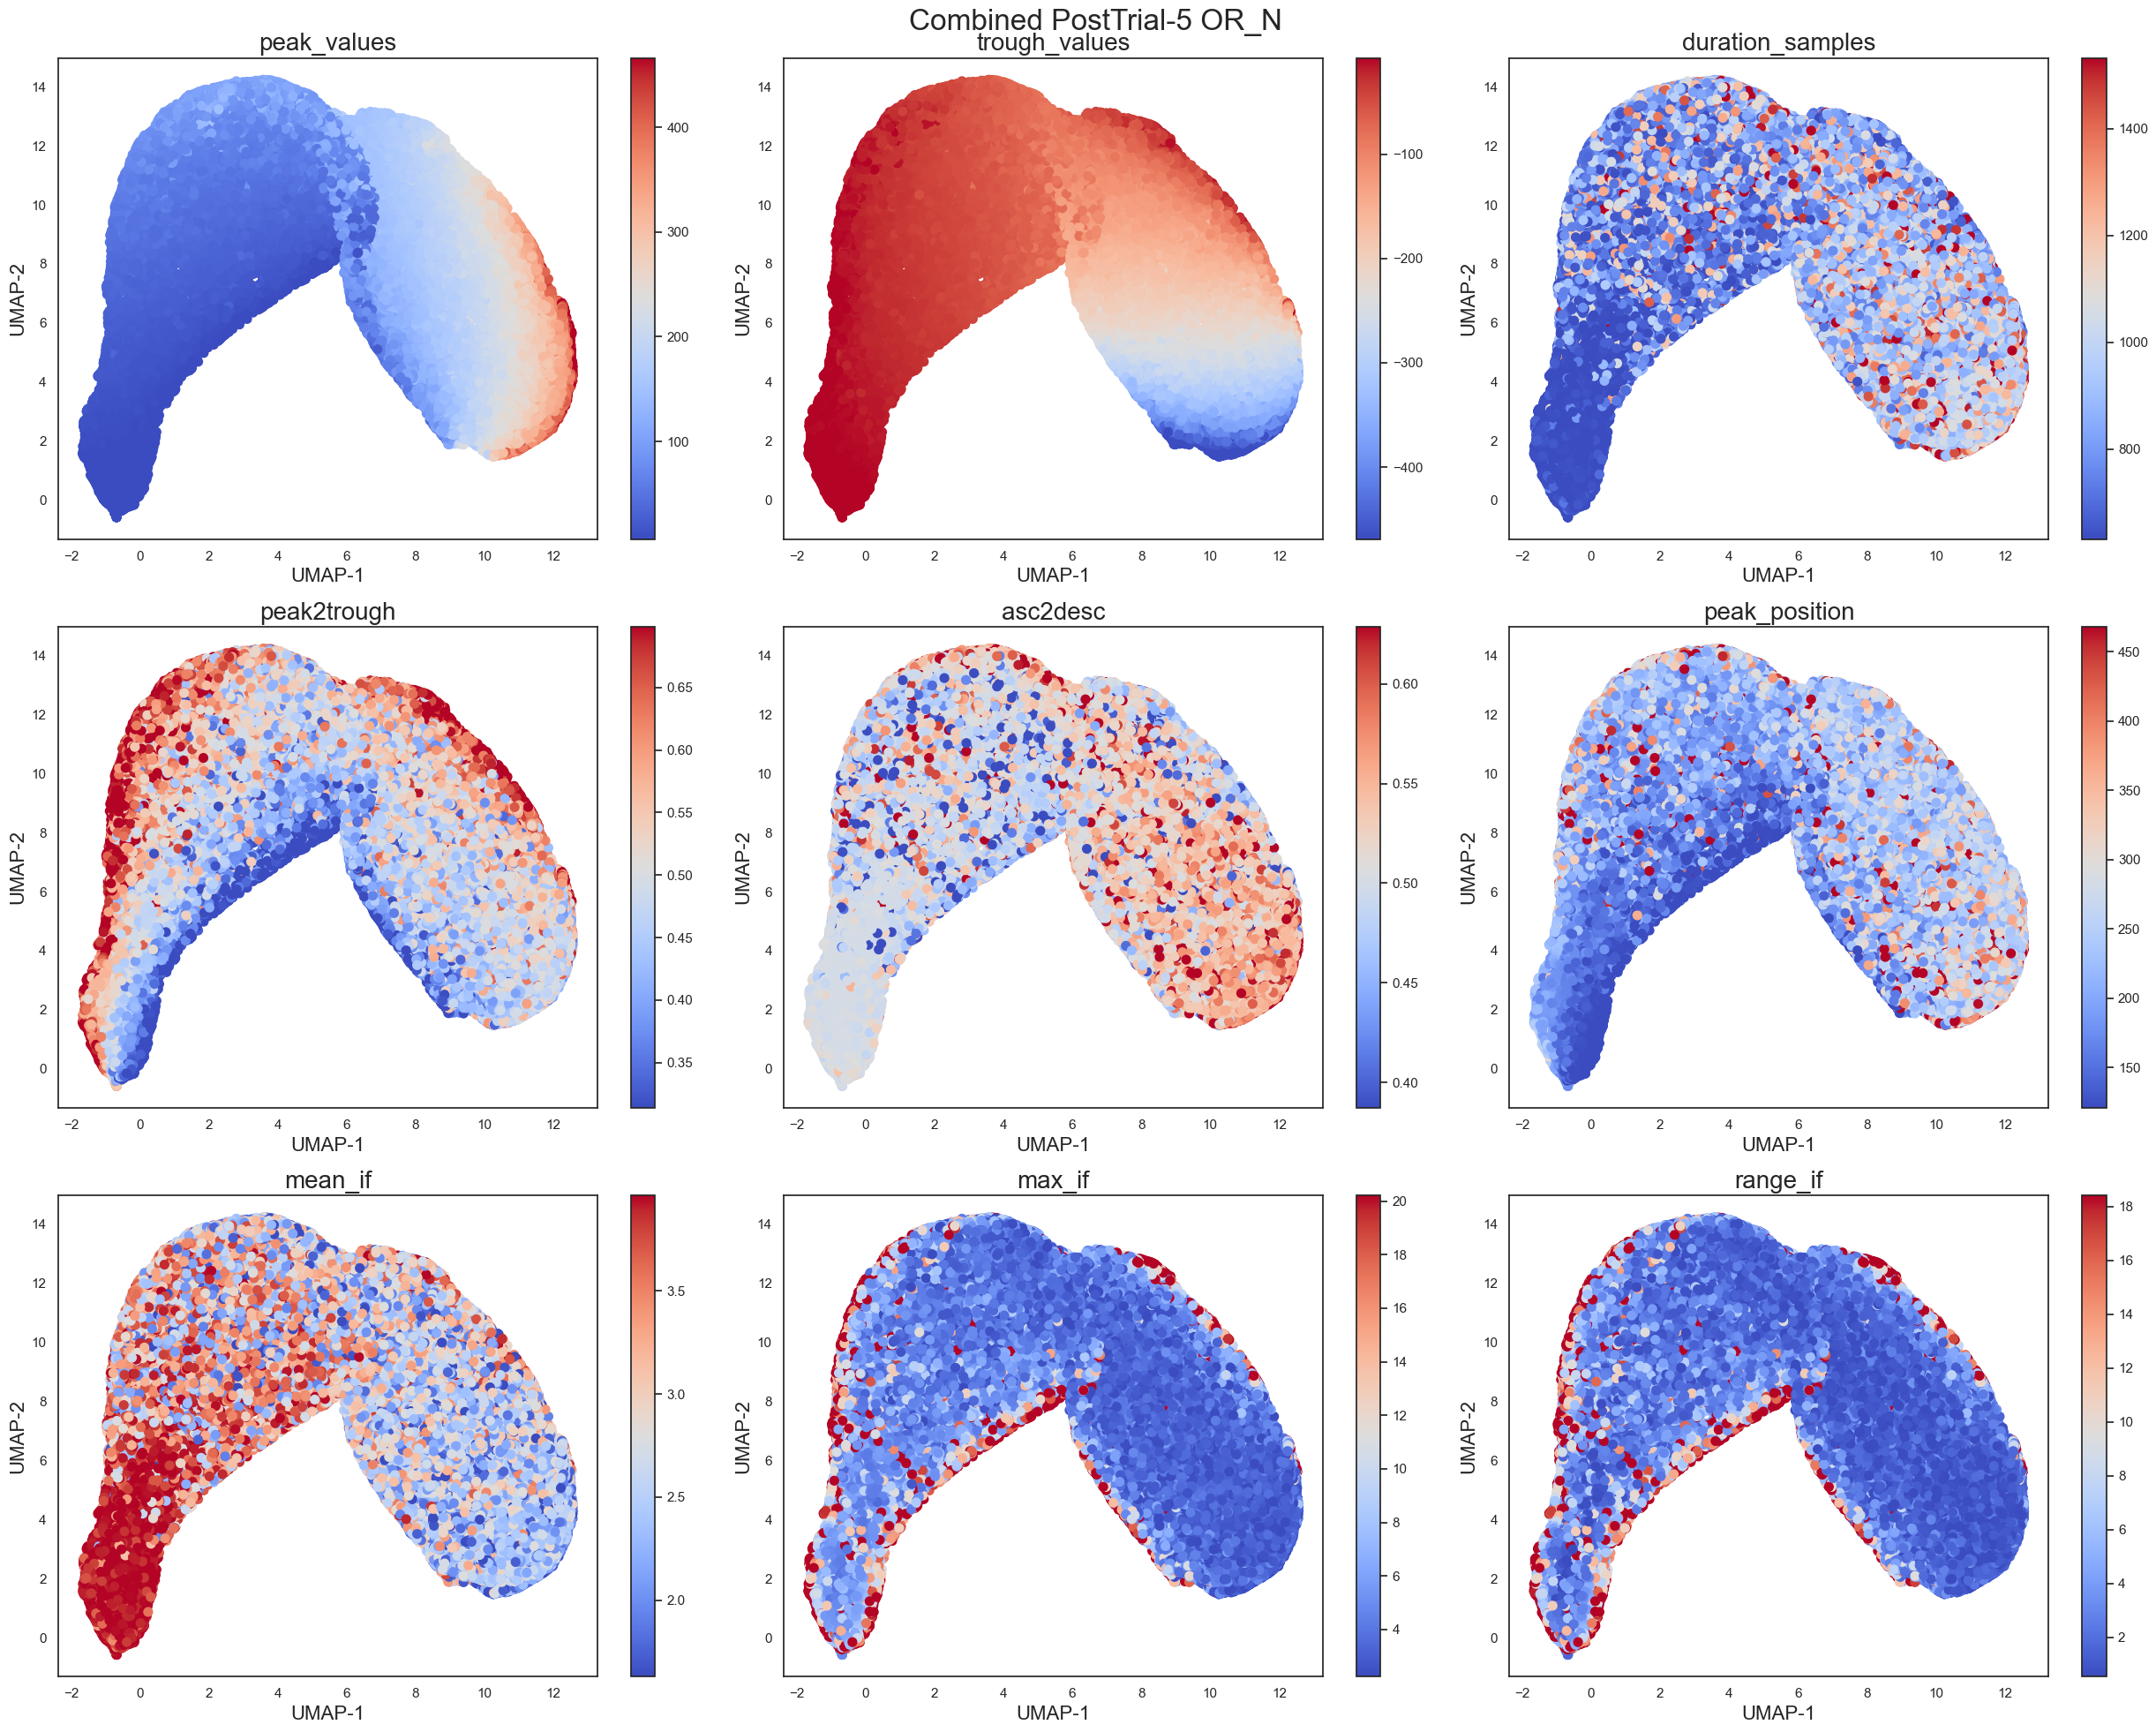

In [91]:
data = metrics

f, ax = plt.subplots(3,3, figsize=(25,20))

features = ['peak_values','trough_values','duration_samples', 'peak2trough', 'asc2desc', 'peak_position', 'mean_if', 'max_if','range_if']
feature_iter = iter(features)

for r in range(3):
    for c in range(3):
        feature = next(feature_iter)
        s = ax[r,c].scatter(emb[:,0], emb[:,1], c=data[feature],
            vmin=np.percentile(data[feature],5),
            vmax=np.percentile(data[feature],95),
            cmap='coolwarm', s=50)
        ax[r,c].set_xlabel('UMAP-1', fontsize=16)
        ax[r,c].set_ylabel('UMAP-2', fontsize=16)
        ax[r,c].set_title(feature, fontsize=20)
        f.colorbar(s, ax=ax[r,c])

plt.suptitle(f"Combined PostTrial-5 OR_N", fontsize=24);
f.tight_layout()
plt.savefig(f"./plots/UMAP-ORN-Whole/PostTrial5_ORN_PFC_2D_embedding_features.png")

# Waveforms

In [93]:
emb_data = pd.DataFrame(embedding.embedding_)
component = 1

In [95]:
data = metrics

low_embeddings = emb_data[(emb_data[component-1] >= np.percentile(emb_data[component-1], 0)) & (emb_data[component-1] <= np.percentile(emb_data[component-1], 20))]
low_waveforms = np.array(pd.DataFrame(waveforms).iloc[low_embeddings.index])

high_embeddings = emb_data[(emb_data[component-1] >= np.percentile(emb_data[component-1], 80)) & (emb_data[component-1] <= np.percentile(emb_data[component-1], 100))]
high_waveforms = np.array(pd.DataFrame(waveforms).iloc[high_embeddings.index])

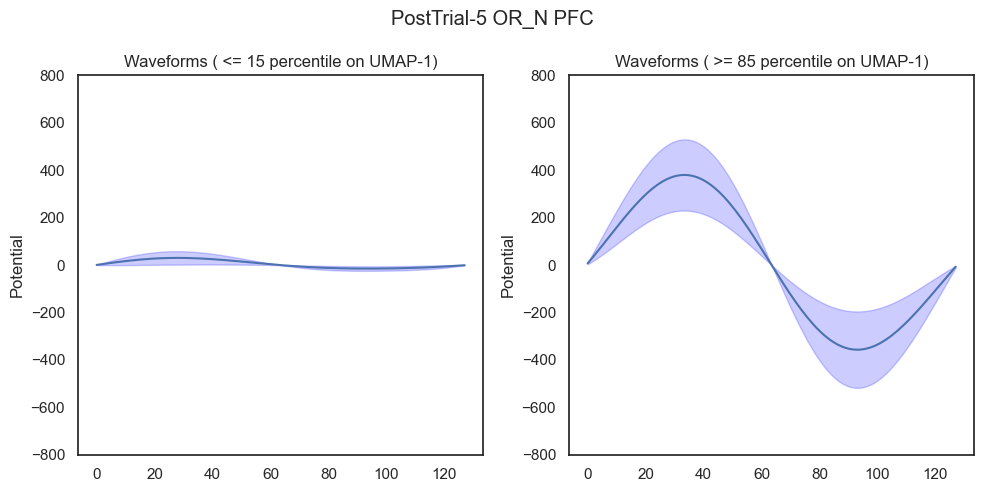

In [105]:
# Average waveforms
plt.figure(figsize=(10,5), facecolor='white')
plt.suptitle(f"PostTrial-5 OR_N PFC")
plt.subplot(1, 2, 1)

means = np.mean(low_waveforms, axis=0)
x_values = np.arange(len(means))
std = np.std(low_waveforms, axis=0)
lower_bound = np.array(means) - np.array(std)
upper_bound = np.array(means) + np.array(std)
sns.lineplot(means)
plt.fill_between(x_values, lower_bound, upper_bound, color='blue', alpha=0.2)
plt.ylabel('Potential')
plt.ylim(-800, 800)
plt.title(f'Waveforms ( <= 15 percentile on UMAP-{component})');

plt.subplot(1, 2, 2)
means = np.mean(high_waveforms, axis=0)
std = np.std(high_waveforms, axis=0)
lower_bound = np.array(means) - np.array(std)
upper_bound = np.array(means) + np.array(std)
sns.lineplot(means)
plt.fill_between(x_values, lower_bound, upper_bound, color='blue', alpha=0.2);
plt.ylabel('Potential')
plt.ylim(-800, 800)
plt.title(f'Waveforms ( >= 85 percentile on UMAP-{component})');
plt.tight_layout()
plt.savefig(f"./plots/UMAP-ORN-Whole/PostTrial5_ORN_PFC_waveforms.png")

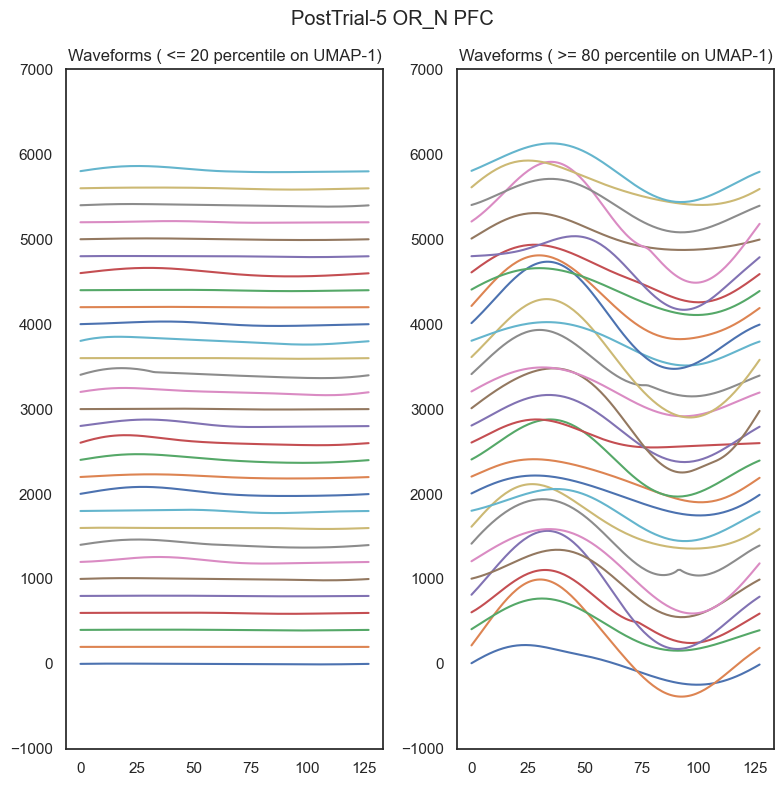

In [107]:
plt.figure(figsize=(8,8), facecolor='white')
plt.suptitle(f"PostTrial-5 OR_N PFC")
plt.subplot(1, 2, 1)
plt.title(f'Waveforms ( <= 20 percentile on UMAP-{component})')
start = 0
cycles_to_plot = np.random.randint(1, low_waveforms.shape[0], 30)
for i in cycles_to_plot:
  plt.plot(low_waveforms[i,:]+start)
  start += 200
plt.ylim((-1000, 7000))

plt.subplot(1, 2, 2)
plt.title(f'Waveforms ( >= 80 percentile on UMAP-{component})')
start = 0
cycles_to_plot = np.random.randint(1, high_waveforms.shape[0], 30)
for i in cycles_to_plot:
  plt.plot(high_waveforms[i,:]+start)
  start += 200
plt.ylim((-1000, 7000))

plt.tight_layout()
plt.savefig(f"./plots/UMAP-ORN-Whole/PostTrial5_ORN_PFC_waveform_examples.png")

# Load Data and get combined embedding

In [7]:
Rat1_data = pd.read_hdf('PFC_cycles_data.h5', 'Rat_1')
Rat3_data = pd.read_hdf('PFC_cycles_data.h5', 'Rat_3')
Rat4_data = pd.read_hdf('PFC_cycles_data.h5', 'Rat_4')
Rat6_data = pd.read_hdf('PFC_cycles_data.h5', 'Rat_6')
Rat13_data = pd.read_hdf('PFC_cycles_data.h5', 'Rat_13')

In [8]:
Rat1_data['rat'] = 1
Rat4_data['rat'] = 4
Rat6_data['rat'] = 6
Rat13_data['rat'] = 13

cols = list(Rat1_data.columns)[:-1]
cols.insert(20, 'rat')

Rat1_data = Rat1_data[cols]
Rat4_data = Rat4_data[cols]
Rat6_data = Rat6_data[cols]
Rat13_data = Rat13_data[cols]

In [269]:
combined_data = pd.concat([Rat1_data,Rat4_data,Rat6_data,Rat13_data])

combined_data = combined_data.drop('index', axis=1)
combined_data = combined_data.drop('is_good', axis=1)
combined_data = combined_data.reset_index(drop=True)

In [271]:
combined_data['section'] = combined_data['start_sample'].apply(get_section)

In [12]:
# metrics = pt5_data.iloc[:, :-128]
waveforms = np.array(combined_data.iloc[:, -128:])

In [14]:
ID = np.round(np.nanmean(abids(waveforms, 50)))
ID

4.0

In [17]:
umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, metric='euclidean', random_state=42)
embedding = umap_embedder.fit(waveforms)
emb = embedding.embedding_

C:\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [273]:
df_emb = pd.DataFrame(emb, columns=['emb1','emb2','emb3'])
combined_data = pd.concat([combined_data, df_emb], axis=1)

In [275]:
combined_data['Post_Trial'] = combined_data.Post_Trial.astype('category')
combined_data['rat'] = combined_data.rat.astype('category')

In [ ]:
combined_data.drop(combined_data[combined_data['start_sample']/(2500*60) > 180].index, inplace=True)

# State-Centroids across time sections

In [440]:
state = 3
section_length = 30

In [442]:
combined_data['section'] = combined_data['start_sample'].apply(get_section,section_length=section_length)

In [444]:
centroids = []

for section in range(1, max(combined_data['section'])+1):
    metrics_section = combined_data[(combined_data['section'] == section) & (combined_data['State'] == state)]
    centroid = np.array(np.mean(metrics_section.iloc[:, -3:], axis=0))
    centroids.append(centroid)

In [ ]:
from copy import deepcopy

data = deepcopy(combined_data)

step_size = 14
height_offsets = {section: (section - 1) * step_size for section in range(1, max(combined_data['section']) +1)}
data['z_offset'] = data['emb3'] + np.array(data['section'].map(height_offsets))

fig = px.scatter_3d(
    x=data['emb1'], 
    y=data['emb2'], 
    z=data['z_offset'],
    color=data['State'],
    # color=data['State'],
    color_discrete_map=state_color_map
)
fig.add_scatter3d(
    x=[centroid[0] for centroid in centroids],
    y=[centroid[1] for centroid in centroids],
    z=[centroid[2] + height_offsets[i + 1] for i, centroid in enumerate(centroids)],
    mode='markers',
    marker=dict(size=10, color='red', symbol='circle', opacity=1),
    name=f'State-{state} Centroid'
)
fig.add_scatter3d(
    x=[centroid[0] for centroid in centroids],
    y=[centroid[1] for centroid in centroids],
    z=[centroid[2] + height_offsets[i + 1] for i, centroid in enumerate(centroids)],
    mode='lines',
    line=dict(color='black', width=2),
    name='Centroid Path'
)
for section, z_pos in height_offsets.items():
    fig.add_trace(
        go.Scatter3d(
            x=[15], y=[-5], z=[z_pos + 5],
            mode='text',
            text=f"{(section-1)*section_length} - {section*section_length} minutes",
            textfont=dict(size=12, color='black'),
            showlegend=False
        )
    )

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    scene=dict(
        xaxis=dict(title='UMAP-1'),
        yaxis=dict(title='UMAP-2'),
        zaxis=dict(title='UMAP-3'),
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=3)
    ),
    legend_title_text="State"
)
fig.show()
fig.write_html(f"./plots/UMAP-ORN-Whole/ORN_PFC_state_across_time.html")
# fig.write_image("Rat13_ORN_split_embedding.png", engine="kaleido")

In [ ]:
# 3D plots of features projected on UMAP
feature = 'peak2trough'

fig = px.scatter_3d(x=combined_data['emb1'], y=combined_data['emb2'], z=combined_data['emb3'],
              color=combined_data[feature])
fig.update_layout(autosize=False,
                  width=800,
                  height=600,
                  scene=Scene(xaxis=XAxis(title='UMAP-1'),
                            yaxis=YAxis(title='UMAP-2'),
                            zaxis=ZAxis(title='UMAP-3')),
                  coloraxis_colorbar_title=feature,
                  coloraxis=dict(
                        cmin=np.percentile(combined_data[feature], 5),
                        cmax=np.percentile(combined_data[feature], 95)
                  )
)
fig.show()
fig.write_html(f"./plots/UMAP-ORN-Whole/CombinedORN_PFC_embedding_{feature}.html")
# fig.write_image(f"{}_ORN_3D_embedding.png", engine="kaleido")

# Rat-Centroids across 4 sections

In [149]:
rat = 4

In [151]:
metrics_section1 = combined_data[(combined_data['section'] == 1) & (combined_data['rat'] == rat)]
metrics_section2 = combined_data[(combined_data['section'] == 2) & (combined_data['rat'] == rat)]
metrics_section3 = combined_data[(combined_data['section'] == 3) & (combined_data['rat'] == rat)]
metrics_section4 = combined_data[(combined_data['section'] == 4) & (combined_data['rat'] == rat)]

centroid_section1 =  np.array(np.mean(metrics_section1.iloc[:, -3:],axis=0))
centroid_section2 =  np.array(np.mean(metrics_section1.iloc[:, -3:],axis=0))
centroid_section3 =  np.array(np.mean(metrics_section1.iloc[:, -3:],axis=0))
centroid_section4 =  np.array(np.mean(metrics_section1.iloc[:, -3:],axis=0))

In [ ]:
from copy import deepcopy
# Split 3D plot with projected sleep states
data = deepcopy(combined_data)

# Assign section based on start_sample and create z_offset using height_offsets
height_offsets = {1: 0, 2: 14, 3: 28, 4: 42}
data['z_offset'] = data['emb3'] + np.array(data['section'].map(height_offsets))

fig = px.scatter_3d(
    x=data['emb1'], 
    y=data['emb2'], 
    z=data['z_offset'],
    color=data['rat'],
    color_discrete_map=state_color_map
)

fig.add_scatter3d(
    x=[centroid_section1[0],centroid_section2[0],centroid_section3[0],centroid_section4[0]],
    y=[centroid_section1[1],centroid_section2[1],centroid_section3[1],centroid_section4[1]],
    z=[centroid_section1[2],centroid_section2[2]+height_offsets[2],centroid_section3[2]+height_offsets[3],centroid_section4[2]+height_offsets[4]],
    mode='markers',
    marker=dict(size=10, color='red', symbol='circle', opacity=1),
    name='Centroid'  # Optional legend label
)

for section, z_pos in height_offsets.items():
    fig.add_trace(
        go.Scatter3d(
            x=[-5], y=[10], z=[z_pos + 5],
            mode='text',
            text=f"{(section-1)*45} - {section*45} minutes",
            textfont=dict(size=12, color='black'),
            showlegend=False
        )
    )

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    scene=dict(
        xaxis=dict(title='UMAP-1'),
        yaxis=dict(title='UMAP-2'),
        zaxis=dict(title='UMAP-3')
    ),
    legend_title_text="State"
)
fig.show()
# fig.write_html(f"./plots/UMAP-ORN-Whole/PostTrial5_ORN_PFC_split_embedding.html")
# fig.write_image("Rat13_ORN_split_embedding.png", engine="kaleido")

# PostTrial_5-Centroids across time sections

In [277]:
def get_section(start_sample, fs=2500, section_length=45):
    section = int(start_sample / (fs * 60) // section_length)+1
    return section

In [311]:
combined_data['section'] = combined_data['start_sample'].apply(get_section,section_length=30)

In [313]:
centroids = []

for section in range(1, max(combined_data['section'])):
    metrics_section = combined_data[(combined_data['section'] == section) & (combined_data['Post_Trial'] == 5)]
    centroid = np.array(np.mean(metrics_section.iloc[:, -3:], axis=0))
    centroids.append(centroid)

In [ ]:
data = deepcopy(combined_data)

step_size = 12
height_offsets = {section: (section - 1) * step_size for section in range(1, max(combined_data['section']) + 1)}
data['z_offset'] = data['emb3'] + np.array(data['section'].map(height_offsets))

fig = px.scatter_3d(
    x=data['emb1'], 
    y=data['emb2'], 
    z=data['z_offset'],
    color=data['Post_Trial'],
    color_discrete_map=state_color_map
)
fig.add_scatter3d(
    x=[centroid[0] for centroid in centroids],
    y=[centroid[1] for centroid in centroids],
    z=[centroid[2] + height_offsets[i + 1] for i, centroid in enumerate(centroids)],
    mode='markers',
    marker=dict(size=10, color='red', symbol='circle', opacity=1),
    name='Centroid'
)
fig.add_scatter3d(
    x=[centroid[0] for centroid in centroids],
    y=[centroid[1] for centroid in centroids],
    z=[centroid[2] + height_offsets[i + 1] for i, centroid in enumerate(centroids)],
    mode='lines',
    line=dict(color='black', width=2),
    name='Centroid Path'
)
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    scene=dict(
        xaxis=dict(title='UMAP-1'),
        yaxis=dict(title='UMAP-2'),
        zaxis=dict(title='UMAP-3'),
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=2.5)
    ),
    legend_title_text="State"
)
fig.show()